In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


## Prediction with explainable AI - Cork City

Let's use this file to predict the prices of houses in Cork City and use explainable AI such as SHAP values to explain the determinants of prices in Cork City. We will then compare this to the same experiment we ran with selected areas of Dublin city.

In [2]:
irl =  pd.read_csv('cork-more-fixed.csv', index_col = 'Unnamed: 0')

In [3]:
irl.head(1)

,Address,County,Price (€),VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,PriceInflation,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar
94123,"10 Deerpark Court, Friars Walk, Cork",Cork,280000.0,1,1,2,2014,1,Cork City,0,Friars Walk Cork City,529951.22,T12,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264


In [4]:
irl.columns

Index(['Address', 'County', 'Price (€)', 'VAT Exclusive',
       'Description of Property', 'Property Size Description', 'Year', 'Month',
       'Town', 'Apartment', 'Neighbourhood', 'PriceInflation', 'Eircode',
       'Latitude', 'Longitude', 'DistanceCenter', 'DistanceSchool',
       'DistancePark', 'DistanceCar'],
      dtype='object')

In [5]:
irl.drop(columns = ['VAT Exclusive', 'County', 'Address', 'Eircode', 'PriceInflation'], inplace = True)

In [6]:
irl.columns

Index(['Price (€)', 'Description of Property', 'Property Size Description',
       'Year', 'Month', 'Town', 'Apartment', 'Neighbourhood', 'Latitude',
       'Longitude', 'DistanceCenter', 'DistanceSchool', 'DistancePark',
       'DistanceCar'],
      dtype='object')

In [7]:
encoder = TargetEncoder()
irl['Neighbourhood'] = encoder.fit_transform(irl['Neighbourhood'], irl['Price (€)'])

In [8]:
encoder = TargetEncoder()
irl['Town'] = encoder.fit_transform(irl['Town'], irl['Price (€)'])

In [9]:
# predicting standard
irl['LogPrice (€)'] = np.log(irl['Price (€)'])
irl.drop(columns = ['Price (€)'], inplace = True)
irl.head()

,Description of Property,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar,LogPrice (€)
94123,1,2,2014,1,238889.733351,0,221996.382933,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264,12.542545
94124,1,1,2014,1,238889.733351,0,342890.105776,51.844802,-8.312442,12.501636,0.597510,5.440909,11.244529,12.821258
94125,1,1,2014,1,238889.733351,0,150351.141667,51.903869,-8.471192,0.626745,0.323214,0.129914,0.238164,11.775290
94126,1,1,2014,1,238889.733351,0,273439.540807,51.911380,-8.450581,2.096941,0.447549,0.669517,1.805214,11.951180
94127,1,1,2014,1,234741.592357,0,234741.592357,51.882655,-8.507208,2.943974,0.503091,0.823622,2.329469,12.254863


In [112]:
irl.shape

(6453, 14)

In [10]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [11]:
from tpot import TPOTRegressor
from sklearn.model_selection import RepeatedKFold

## 2021

### TPOT

In [12]:
specific21 = irl[irl['Year'] > 2017]

In [13]:
train_21 = specific21[specific21['Year'] < 2021]

In [14]:
test_21 = specific21[specific21['Year'] == 2021]

In [15]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [16]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

x_t_21 = x_test_21

In [17]:
#cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define search
model = TPOTRegressor(max_time_mins = 10)
model1 = model.fit(x_train_21, y_train_21)

In [18]:
#model1.export('tpot_2021_pipeline.py')

In [19]:
# calculated values
from sklearn.metrics import mean_squared_error
y_predicted_21 = model1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_21), np.exp(y_predicted_21))
print('MSE for TPOT AutoML 2021 is: ' + str(mse))

MSE for TPOT AutoML 2021 is: 19622562233.37063


In [20]:
rmse = mean_squared_error(np.exp(y_test_21), np.exp(y_predicted_21), squared=False)
print('RMSE for TPOT AutoML 2021 is: ' + str(rmse))

RMSE for TPOT AutoML 2021 is: 140080.55622880225


In [21]:
median_se = np.square(np.subtract(np.exp(y_test_21), np.exp(y_predicted_21))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

54995.49639534478


In [22]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_21), np.exp(y_predicted_21))
print("MAPE for TPOT AutoML 2021 is: " + str(mape))

MAPE for TPOT AutoML 2021 is: 0.30630442328479324


In [23]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Cork AutoML 2021 accuracy is: ' + str(acc))

Cork AutoML 2021 accuracy is: 0.2427055702917772


In [113]:
%%capture
import shap
explainer = shap.Explainer(model1.predict, x_test_21)
shap_values = explainer(x_test_21)

In [114]:
vals = np.abs(shap_values.values).mean(0)
feature_names = x_test_21.columns

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance.head()

,col_name,feature_importance_vals
6,Neighbourhood,0.266325
3,Month,0.016850
4,Town,0.014714
12,DistanceCar,0.009058
5,Apartment,0.006988


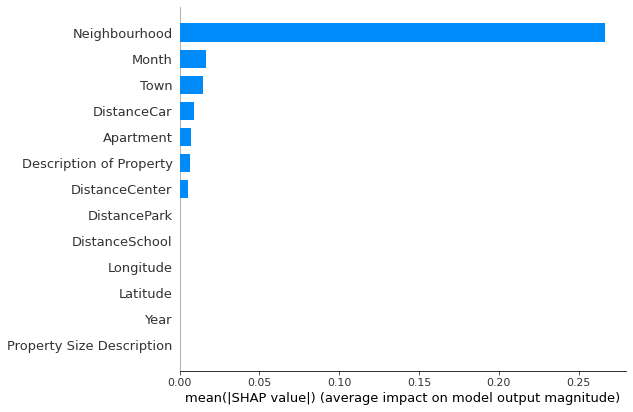

In [115]:
shap.summary_plot(shap_values, x_test_21, plot_type = 'bar')

In [26]:
#f = plt.figure()
#shap.summary_plot(shap_values, x_test_21)
#f.savefig("summary_plot21cork.png", bbox_inches = 'tight', dpi = 600)

In [27]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'TPOT AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [28]:
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020

In [29]:
specific20 = irl[irl['Year'] > 2016]

In [30]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

x_t_20 = x_test_20

In [31]:
model = TPOTRegressor(max_time_mins = 10)
model2 = model.fit(x_train_20, y_train_20)

In [32]:
#model2.export('tpot_2020_pipeline.py')

In [33]:
y_predicted_20 = model1.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_20), np.exp(y_predicted_20))
print('MSE for TPOT AutoML 2020 is: ' + str(mse))

MSE for TPOT AutoML 2020 is: 15873626032.926266


In [34]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_20), np.exp(y_predicted_20))
print("MAPE for TPOT AutoML 2020 is: " + str(mape))

MAPE for TPOT AutoML 2020 is: 0.300832802179203


In [35]:
median_se = np.square(np.subtract(np.exp(y_test_20), np.exp(y_predicted_20))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

42198.23680708967


In [36]:
rmse = mean_squared_error(np.exp(y_test_20), np.exp(y_predicted_20), squared=False)
print('RMSE for TPOT AutoML 2020 is: ' + str(rmse))

RMSE for TPOT AutoML 2020 is: 125990.57914354655


In [37]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Cork AutoML 2020 accuracy is: ' + str(acc))

Cork AutoML 2020 accuracy is: 0.32535211267605635


In [38]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns=cnames)

df12 = df12.append({'Algorithm': 'TPOT AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [39]:
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)

In [116]:
%%capture
explainer = shap.Explainer(model2.predict, x_test_20)
shap_values2 = explainer(x_test_20)

In [117]:
vals1 = np.abs(shap_values2.values).mean(0)
feature_names1 = x_test_20.columns

feature_importance1 = pd.DataFrame(list(zip(feature_names1, vals1)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance1.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance1.head()

,col_name,feature_importance_vals
6,Neighbourhood,0.283709
12,DistanceCar,0.026207
11,DistancePark,0.018587
4,Town,0.017247
0,Description of Property,0.013083


In [118]:
#f = plt.figure()
#shap.summary_plot(shap_values2, x_test_20)
#f.savefig("summary_plot20cork.png", bbox_inches = 'tight', dpi = 600)

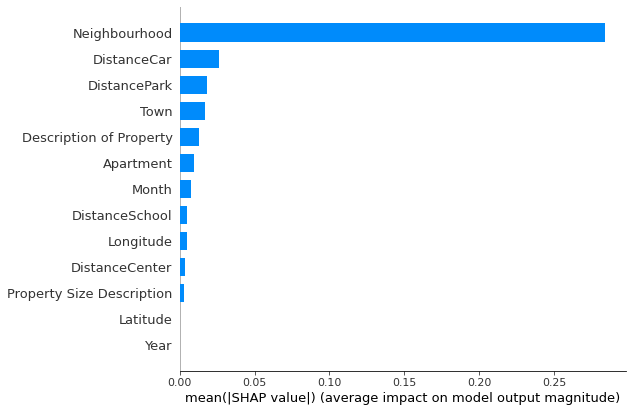

In [119]:
shap.summary_plot(shap_values2, x_test_20, plot_type = 'bar')

### 2019

In [43]:
specific19 = irl[irl['Year'] > 2015]

In [44]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

x_t_19 = x_test_19

In [45]:
model = TPOTRegressor(max_time_mins = 10)
# perform the search // takes ages to run!
model3 = model.fit(x_train_19, y_train_19)

In [46]:
#model3.export('tpot_2019_pipeline.py')

In [47]:
y_predicted_19 = model1.predict(x_test_19)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_19), np.exp(y_predicted_19))
print('MSE for TPOT AutoML 2019 is: ' + str(mse))

MSE for TPOT AutoML 2019 is: 16430301491.87497


In [48]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_19), np.exp(y_predicted_19))
print("MAPE for TPOT AutoML 2019 is: " + str(mape))

MAPE for TPOT AutoML 2019 is: 0.301752535795127


In [49]:
median_se = np.square(np.subtract(np.exp(y_test_19), np.exp(y_predicted_19))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

42403.167164491606


In [50]:
rmse = mean_squared_error(np.exp(y_test_19), np.exp(y_predicted_19), squared = False)
print('RMSE for TPOT AutoML 2019 is: ' + str(rmse))

RMSE for TPOT AutoML 2019 is: 128180.73760076032


In [51]:
acc = accuracy_threshold(y_test_19, y_predicted_19, 0.1)
print('Cork AutoML 2019 accuracy is: ' + str(acc))

Cork AutoML 2019 accuracy is: 0.3070063694267516


In [120]:
%%capture
explainer = shap.Explainer(model3.predict, x_test_19)
shap_values3 = explainer(x_test_19)

In [121]:
vals2 = np.abs(shap_values3.values).mean(0)
feature_names2 = x_test_19.columns

feature_importance2 = pd.DataFrame(list(zip(feature_names2, vals2)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance2.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance2.head()

,col_name,feature_importance_vals
6,Neighbourhood,0.231977
9,DistanceCenter,0.040007
12,DistanceCar,0.035077
11,DistancePark,0.016031
3,Month,0.015646


In [122]:
#f = plt.figure()
#shap.summary_plot(shap_values3, x_test_19)
#f.savefig("summary_plot19cork.png", bbox_inches = 'tight', dpi = 600)

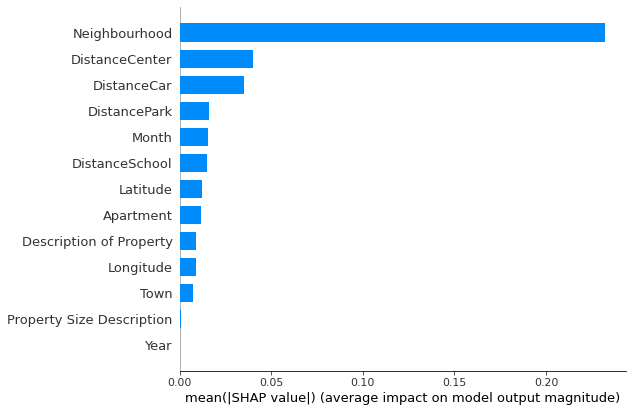

In [123]:
shap.summary_plot(shap_values3, x_test_19, plot_type = 'bar')

In [55]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'TPOT AutoML',
            'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [56]:
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_predicted_19)

### 2018

In [57]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

x_t_18 = x_test_18

In [58]:
model = TPOTRegressor(max_time_mins = 10)
# perform the search // takes ages to run!
model4 = model.fit(x_train_18, y_train_18)

In [59]:
#model4.export('tpot_2018_pipeline.py')

In [60]:
y_predicted_18 = model1.predict(x_test_18)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_18), np.exp(y_predicted_18))
print('MSE for TPOT AutoML 2018 is: ' + str(mse))

MSE for TPOT AutoML 2018 is: 15965550827.508694


In [61]:
rmse = mean_squared_error(np.exp(y_test_18), np.exp(y_predicted_18), squared = False)
print('RMSE for TPOT AutoML 2018 is: ' + str(rmse))

RMSE for TPOT AutoML 2018 is: 126354.86071975503


In [62]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_18), np.exp(y_predicted_18))
print("MAPE for TPOT AutoML 2018 is: " + str(mape))

MAPE for TPOT AutoML 2018 is: 0.3352897827138748


In [63]:
median_se = np.square(np.subtract(np.exp(y_test_18), np.exp(y_predicted_18))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

47959.27634272987


In [64]:
acc = accuracy_threshold(y_test_18, y_predicted_18, 0.1)
print('Cork AutoML 2018 accuracy is: ' + str(acc))

Cork AutoML 2018 accuracy is: 0.2743055555555556


In [124]:
%%capture
explainer = shap.Explainer(model4.predict, x_test_18)
shap_values4 = explainer(x_test_18)

In [125]:
vals3 = np.abs(shap_values4.values).mean(0)
feature_names3 = x_test_18.columns

feature_importance3 = pd.DataFrame(list(zip(feature_names3, vals3)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance3.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance3.head()

,col_name,feature_importance_vals
6,Neighbourhood,0.275542
12,DistanceCar,0.141658
9,DistanceCenter,0.132643
10,DistanceSchool,0.024899
5,Apartment,0.022728


In [126]:
#f = plt.figure()
#shap.summary_plot(shap_values4, x_test_18)
#f.savefig("summary_plot18cork.png", bbox_inches = 'tight', dpi = 600)

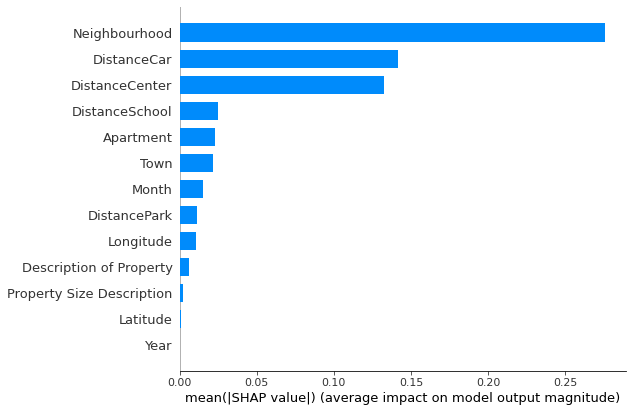

In [127]:
shap.summary_plot(shap_values4, x_test_18, plot_type = 'bar')

In [68]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns=cnames)

df14 = df14.append({'Algorithm': 'TPOT AutoML',
            'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [69]:
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_predicted_18)

### 2017

In [70]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

x_t_17 = x_test_17

In [71]:
model = TPOTRegressor(max_time_mins = 10)
# perform the search // takes ages to run!
model5 = model.fit(x_train_17, y_train_17)

In [72]:
#model5.export('tpot_2017_pipeline.py')

In [73]:
y_predicted_17 = model1.predict(x_test_17)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_17), np.exp(y_predicted_17))
print('MSE for TPOT AutoML 2017 is: ' + str(mse))

MSE for TPOT AutoML 2017 is: 18311022264.823505


In [74]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_17), np.exp(y_predicted_17))
print("MAPE for TPOT AutoML 2017 is: " + str(mape))

MAPE for TPOT AutoML 2017 is: 0.38161990865938916


In [75]:
median_se = np.square(np.subtract(np.exp(y_test_17), np.exp(y_predicted_17))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

49882.25019232324


In [76]:
rmse = mean_squared_error(np.exp(y_test_17), np.exp(y_predicted_17), squared = False)
print('RMSE for TPOT AutoML 2017 is: ' + str(rmse))

RMSE for TPOT AutoML 2017 is: 135318.22591514976


In [77]:
acc = accuracy_threshold(y_test_17, y_predicted_17, 0.1)
print('Cork AutoML 2017 accuracy is: ' + str(acc))

Cork AutoML 2017 accuracy is: 0.23927038626609443


In [128]:
%%capture
explainer = shap.Explainer(model5.predict, x_test_17)
shap_values5 = explainer(x_test_17)

In [129]:
vals4 = np.abs(shap_values5.values).mean(0)
feature_names4 = x_test_17.columns

feature_importance4 = pd.DataFrame(list(zip(feature_names4, vals4)),
                                 columns = ['col_name','feature_importance_vals'])
feature_importance4.sort_values(by = ['feature_importance_vals'],
                              ascending = False, inplace = True)
feature_importance4.head()

,col_name,feature_importance_vals
6,Neighbourhood,0.216587
4,Town,0.034436
7,Latitude,0.026465
9,DistanceCenter,0.018073
8,Longitude,0.017435


In [130]:
#f = plt.figure()
#shap.summary_plot(shap_values5, x_test_17)
#f.savefig("summary_plot17cork.png", bbox_inches = 'tight', dpi = 600)

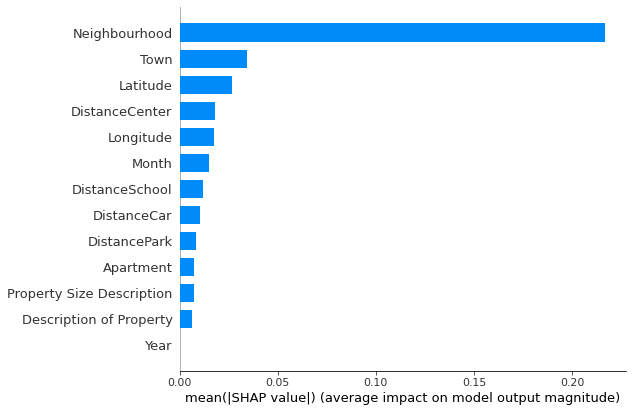

In [131]:
shap.summary_plot(shap_values5, x_train_17, plot_type = 'bar')

In [81]:
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_predicted_17)

In [82]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns=cnames)

df15 = df15.append({'Algorithm': 'TPOT AutoML',
            'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [83]:
vis1 = pd.concat([df11, df12, df13, df14, df15], ignore_index=True)

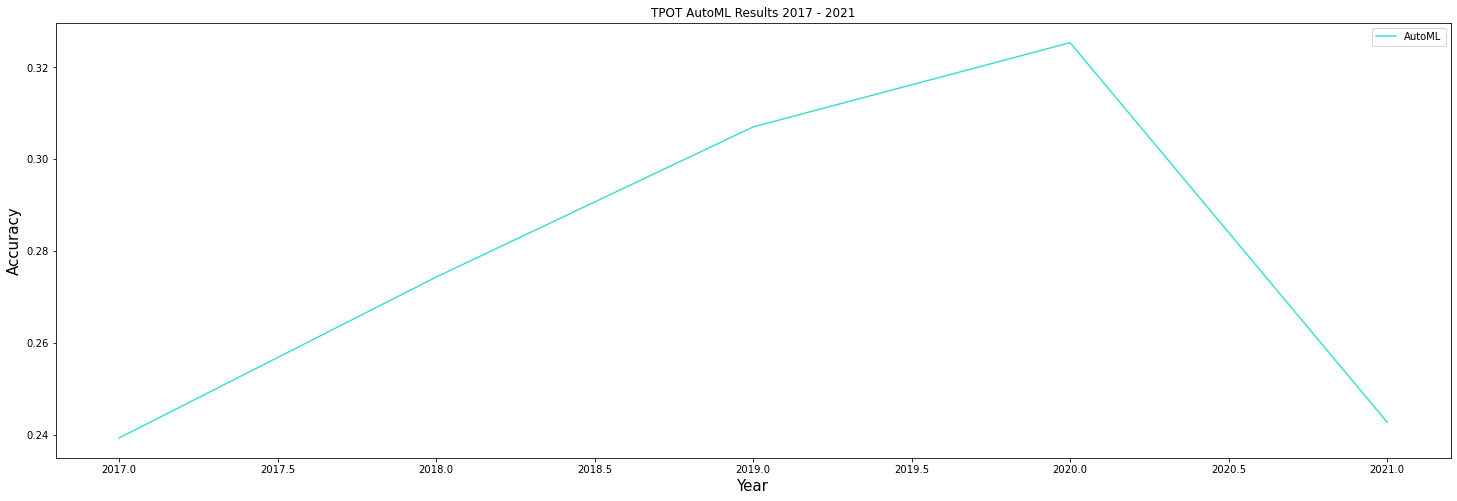

In [84]:
# don't need cross validation same training due to set intervals?
plt.subplots(figsize = (25, 8))
plt.plot(vis1['Year'], vis1['Accuracy'], label = 'AutoML', color = 'turquoise')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('TPOT AutoML Results 2017 - 2021')
plt.legend()
plt.show()

In [85]:
print("Mean accuracy for TPOT AutoML over period 2017-2021 is: " + str(vis1['Accuracy'].mean()))
# Mean accuracy for TPOT AutoML over period 2017-2021 is: 0.3296431521892442

Mean accuracy for TPOT AutoML over period 2017-2021 is: 0.277727998843247


In [86]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4, dfreal5], ignore_index = True)
actual.rename(columns = {0: 'Actual'}, inplace = True)
actual.head()

,Actual
0,11.976659
1,12.421184
2,12.028739
3,12.570716
4,12.367341


In [87]:
pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4, dfpred5], ignore_index = True)
pred.rename(columns={0: 'Predicted'}, inplace = True)
pred.head()

,Predicted
0,12.196519
1,12.325097
2,11.844082
3,11.975397
4,12.396661


In [88]:
actualvpred = actual.join(pred)

In [89]:
actualvpred.head()

,Actual,Predicted
0,11.976659,12.196519
1,12.421184,12.325097
2,12.028739,11.844082
3,12.570716,11.975397
4,12.367341,12.396661


In [90]:
exp = np.exp(actualvpred)

In [91]:
exp.shape

(4045, 2)

In [92]:
x_t_21 = x_t_21.reset_index()
x_t_20 = x_t_20.reset_index()
x_t_19 = x_t_19.reset_index()
x_t_18 = x_t_18.reset_index()
x_t_17 = x_t_17.reset_index()

x_t_21.drop(columns = ['index'], inplace = True)
x_t_20.drop(columns = ['index'], inplace = True)
x_t_19.drop(columns = ['index'], inplace = True)
x_t_18.drop(columns = ['index'], inplace = True)
x_t_17.drop(columns = ['index'], inplace = True)

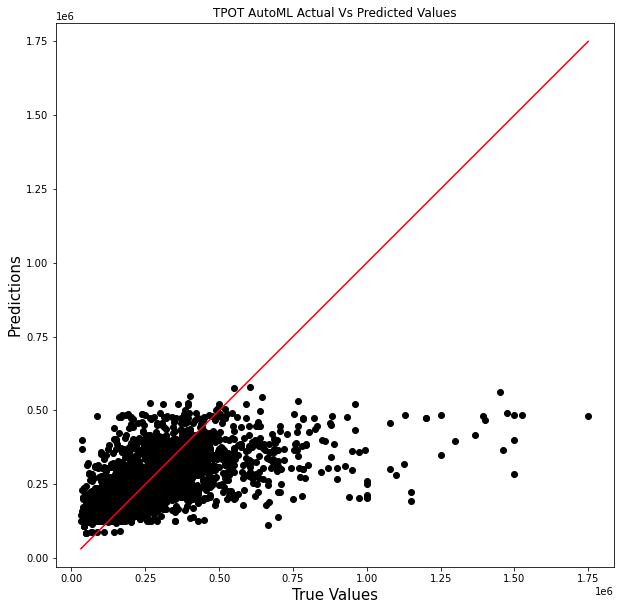

In [93]:
# plot predicted vs actual
## this is using actual prices hence adjusted scale compared to mljar plot
plt.figure(figsize = (10, 10))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'black')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.title('TPOT AutoML Actual Vs Predicted Values')
plt.axis('equal')
plt.show()

In [94]:
import geopandas as gpd
cork_map = gpd.read_file('cork-city-boundary\Cork City BoundaryWGS84.shp')  #reading the shape file for our maps 
cork_map.head(1)

2022-04-26 14:48:08,599 fiona._env ERROR Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.
2022-04-26 14:48:08,601 fiona._env ERROR Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


,Latitude,Longtitude,ENGLISH,CONTAE,COUNTY,AREA,PROVINCE,geometry
0,51.905,-8.384,CORK CITY COUNCIL,Corcaigh,CORK,186597605.50694406,Munster,"POLYGON ((-8.38436 51.90533, -8.38425 51.90529..."


In [95]:
l1 = dfreal1.join(x_t_21[['Longitude', 'Latitude']])
l2 = dfreal2.join(x_t_20[['Longitude', 'Latitude']])
l3 = dfreal3.join(x_t_19[['Longitude', 'Latitude']])
l4 = dfreal4.join(x_t_18[['Longitude', 'Latitude']])
l5 = dfreal5.join(x_t_17[['Longitude', 'Latitude']])

plots = pd.concat([l1, l2, l3, l4, l5], ignore_index = True)
plots.head()

,0,Longitude,Latitude
0,11.976659,-8.337650,51.873131
1,12.421184,-8.445846,51.917272
2,12.028739,-8.478741,51.915242
3,12.570716,-8.461265,51.907005
4,12.367341,-8.505025,51.882794


In [96]:
#plots = pd.concat([l1, l2, l3, l4, l5], ignore_index=True)

In [97]:
plots.rename(columns = {0 : 'Actual'}, inplace = True)

In [98]:
plotscomp = plots.join(pred)
plotscomp.head()

,Actual,Longitude,Latitude,Predicted
0,11.976659,-8.337650,51.873131,12.196519
1,12.421184,-8.445846,51.917272,12.325097
2,12.028739,-8.478741,51.915242,11.844082
3,12.570716,-8.461265,51.907005,11.975397
4,12.367341,-8.505025,51.882794,12.396661


In [99]:
exp1 = np.exp(plotscomp[['Actual', 'Predicted']])

In [100]:
exp1 = exp1.join(plotscomp[['Longitude', 'Latitude']])

In [101]:
exp1.head()

,Actual,Predicted,Longitude,Latitude
0,159000.0,198098.336917,-8.337650,51.873131
1,248000.0,225279.512765,-8.445846,51.917272
2,167500.0,139257.729830,-8.478741,51.915242
3,288000.0,158799.445657,-8.461265,51.907005
4,235000.0,241992.331787,-8.505025,51.882794


In [102]:
num = 0.1
lst = []
test = np.array(exp1['Actual'])
pred = np.array(exp1['Predicted'])
count = 0
for i in range(len(pred)):
    if test[i] != 0:  
        ten = test[i] * num
        res = test[i] - pred[i]
    else:
        res = 0
        ten = 0
        
    if res < 0:
        res = res * -1
    else:
        res = res
            
    if res <= ten:
        lst.append(1)
    else:
        lst.append(0)

In [103]:
exp1['Accurate'] = lst

In [104]:
exp1.head()

,Actual,Predicted,Longitude,Latitude,Accurate
0,159000.0,198098.336917,-8.337650,51.873131,0
1,248000.0,225279.512765,-8.445846,51.917272,1
2,167500.0,139257.729830,-8.478741,51.915242,0
3,288000.0,158799.445657,-8.461265,51.907005,0
4,235000.0,241992.331787,-8.505025,51.882794,1


In [108]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap1 = ListedColormap(["red", "limegreen"])

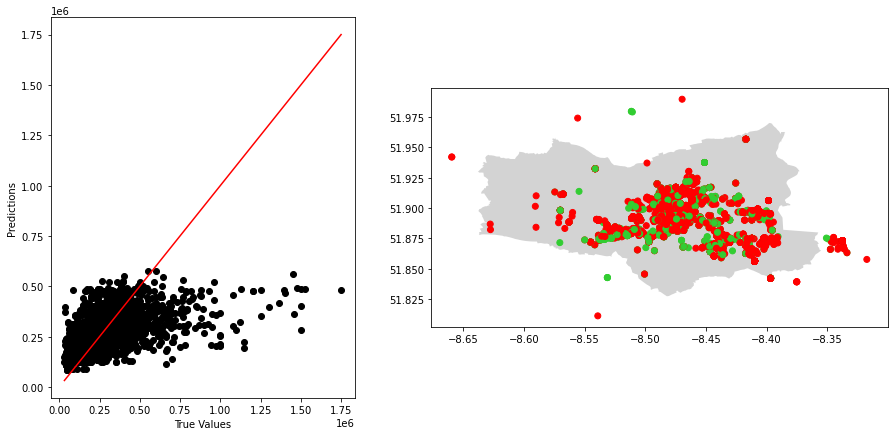

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7), gridspec_kw={'width_ratios': [1, 1.5]})
#fig.tight_layout()
#sns.histplot(df['Price'], ax=ax1)
ax1.scatter(exp['Actual'], exp['Predicted'], c = 'black')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
ax1.plot([p1, p2], [p1, p2], 'r-')
ax1.set_xlabel('True Values', fontsize = 10)
ax1.set_ylabel('Predictions', fontsize = 10)

# cork map
cork_map.plot(ax = ax2, color = 'lightgrey')
#ax.axhline(y = 53.34975, color = 'r', linestyle = '--')
plt.scatter(x = exp1['Longitude'], y = exp1['Latitude'], c = exp1['Accurate'], cmap = cmap1)
#plt.title('Plot of Locations of Accurately Predicted properties used in test dataset')
#plt.colorbar()
#plt.title('TPOT AutoML Actual Vs Predicted Values')
#plt.axis('equal')

fig.savefig('cork-comparison.png', bbox_inches='tight')
plt.show()

In [106]:
vis1

,Algorithm,Year,RMSE,MSE,MEDAE,Accuracy,MAPE
0,TPOT AutoML,2021,140080.556229,1.962256e+10,54995.496395,0.242706,0.306304
1,TPOT AutoML,2020,125990.579144,1.587363e+10,42198.236807,0.325352,0.300833
2,TPOT AutoML,2019,128180.737601,1.643030e+10,42403.167164,0.307006,0.301753
3,TPOT AutoML,2018,126354.860720,1.596555e+10,47959.276343,0.274306,0.335290
4,TPOT AutoML,2017,135318.225915,1.831102e+10,49882.250192,0.239270,0.381620


In [107]:
valuess = pd.DataFrame(vis1[['RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']].mean())
valuess.rename(columns={0: 'Averages'}, inplace = True)
valuess.style.format("{:.3f}")

,Averages
RMSE,131184.992
MSE,17240612570.101
MEDAE,47487.685
Accuracy,0.278
MAPE,0.325


In [132]:
s1 = pd.merge(feature_importance, feature_importance1, on = 'col_name', how='inner')
s2 = pd.merge(s1, feature_importance2, on = 'col_name', how='inner')
s3 = pd.merge(s2, feature_importance3, on = 'col_name', how='inner')
s4 = pd.merge(s3, feature_importance4, on = 'col_name', how='inner')
s4

Passing 'suffixes' which cause duplicate columns {'feature_importance_vals_x'} in the result is deprecated and will raise a MergeError in a future version.


,col_name,feature_importance_vals_x,feature_importance_vals_y,feature_importance_vals_x,feature_importance_vals_y,feature_importance_vals
0,Neighbourhood,0.266325,2.837093e-01,0.231977,0.275542,0.216587
1,Month,0.016850,7.346196e-03,0.015646,0.015078,0.015130
2,Town,0.014714,1.724651e-02,0.007104,0.021643,0.034436
3,DistanceCar,0.009058,2.620679e-02,0.035077,0.141658,0.010420
4,Apartment,0.006988,9.349177e-03,0.011609,0.022728,0.007543
5,Description of Property,0.006292,1.308313e-02,0.008930,0.006411,0.006560
6,DistanceCenter,0.005288,3.636093e-03,0.040007,0.132643,0.018073
7,Property Size Description,0.000000,3.093225e-03,0.000795,0.002006,0.007307
8,Year,0.000000,0.000000e+00,0.000000,0.000000,0.000000
9,Latitude,0.000000,1.536367e-09,0.012352,0.000962,0.026465


In [133]:
s4.columns = ['col_name', '1', '2', '3', '4', '5']
s4

,col_name,1,2,3,4,5
0,Neighbourhood,0.266325,2.837093e-01,0.231977,0.275542,0.216587
1,Month,0.016850,7.346196e-03,0.015646,0.015078,0.015130
2,Town,0.014714,1.724651e-02,0.007104,0.021643,0.034436
3,DistanceCar,0.009058,2.620679e-02,0.035077,0.141658,0.010420
4,Apartment,0.006988,9.349177e-03,0.011609,0.022728,0.007543
5,Description of Property,0.006292,1.308313e-02,0.008930,0.006411,0.006560
6,DistanceCenter,0.005288,3.636093e-03,0.040007,0.132643,0.018073
7,Property Size Description,0.000000,3.093225e-03,0.000795,0.002006,0.007307
8,Year,0.000000,0.000000e+00,0.000000,0.000000,0.000000
9,Latitude,0.000000,1.536367e-09,0.012352,0.000962,0.026465


In [134]:
sum_column = s4["1"] + s4["2"] + s4["3"] + s4["4"] + s4["5"]
s4['sumshap'] = sum_column
s4['avgshap'] = sum_column / 5

In [135]:
s4 = s4.sort_values(by=['avgshap'], ascending = False)

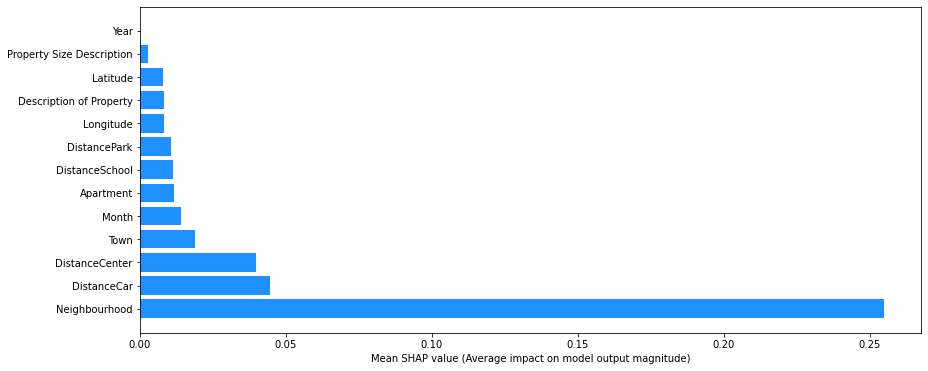

In [136]:
# creating the bar plot
figz = plt.figure(figsize=(14, 6))

plt.barh(s4['col_name'], s4['avgshap'], color = 'dodgerblue')

plt.xlabel("Mean SHAP value (Average impact on model output magnitude)")
figz.savefig('cork-mean-shap.png', bbox_inches = 'tight')
plt.show()